In [ ]:
%%capture
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **데이터 로드 (2024년)**

In [ ]:
df2024 = pd.read_excel("/content/drive/MyDrive/관광공모전/data/sav/2024.xlsx")

In [ ]:
df = df2024.copy()
df.head()

,pnid,MVIT,RVIT,XRVIT,TYP,Q1,Q1_1a1,Q1_1a2,Q1_1a3,Q2a1,...,D_SEX,D_AGE,D_MOK,D_NUM,D_GUB,weight1,weight2,weight3,weight4,weight
0,57,5,4회 이상,재방문,"개별여행 : 일정, 숙박 등 여행의 모든 준비를 직접 수행","여가, 위락, 휴식","한류 콘텐츠(K-pop, 드라마, 영화 등)를 접하고 나서",NaN,NaN,NaN,...,여 성,50 대,여 가/위 락/ 휴 식,4 회 이 상,개 별 여 행,198.017146,NaN,NaN,NaN,198.017146
1,58,4,4회 이상,재방문,"개별여행 : 일정, 숙박 등 여행의 모든 준비를 직접 수행","여가, 위락, 휴식","한류 콘텐츠(K-pop, 드라마, 영화 등)를 접하고 나서","한국의 가성비 높은 여행 상품(패키지, 항공권 등)을 접하고 나서",과거 방문 경험이 좋아서,일본,...,여 성,40 대,여 가/위 락/ 휴 식,4 회 이 상,개 별 여 행,784.278401,NaN,NaN,NaN,784.278401
2,59,3,3회,재방문,"개별여행 : 일정, 숙박 등 여행의 모든 준비를 직접 수행","여가, 위락, 휴식","한류 콘텐츠(K-pop, 드라마, 영화 등)를 접하고 나서",과거 방문 경험이 좋아서,"한국 전통문화(한복, 한식 등 고유문화)를 접하고 나서",일본,...,여 성,30 대,여 가/위 락/ 휴 식,3 회,개 별 여 행,607.021269,NaN,NaN,NaN,607.021269
3,60,1,1회,NaN,"개별여행 : 일정, 숙박 등 여행의 모든 준비를 직접 수행","여가, 위락, 휴식","한국 전통문화(한복, 한식 등 고유문화)를 접하고 나서","한류 콘텐츠(K-pop, 드라마, 영화 등)를 접하고 나서","한국에서 행사(가족행사, 스포츠 행사 등)가 있어서",NaN,...,남 성,20 대,여 가/위 락/ 휴 식,1 회,개 별 여 행,1049.500143,NaN,NaN,NaN,1049.500143
4,61,5,4회 이상,재방문,"개별여행 : 일정, 숙박 등 여행의 모든 준비를 직접 수행","여가, 위락, 휴식",과거 방문 경험이 좋아서,한국의 다양한 관광지 관련 정보를 접하고 나서,"한국의 가성비 높은 여행 상품(패키지, 항공권 등)을 접하고 나서",홍콩,...,여 성,20 대,여 가/위 락/ 휴 식,4 회 이 상,개 별 여 행,876.796936,NaN,NaN,NaN,876.796936


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16216 entries, 0 to 16215
Columns: 402 entries, pnid to weight
dtypes: float64(137), int64(19), object(246)
memory usage: 49.7+ MB


## **변수 선택**

1. 체류 & 소비
- [M일HAP] : 총 체류일수
- [총액1인TOT2] : 1인당 총 지출 경비

<br>

2. 만족도 (매핑 적용)
- [Q11] : 전반적 만족도
- [Q13] : 재방문 의사
- [Q14] : 타인 추천 의향

<br>

3. 체험 활동 (다중응답 -> 이진화)
- [Q8a01] : 식도각 관광 참여 여부
- [Q8a08] : Kpop 공연/촬영지 방문 여부
- [Q8a13] : 뷰티/미용 관광 참여 여부
- [Q8a20] : 기타 활동 참여 여부

<br>

4. 쇼핑 항목 (다중응답 -> 이진화)
- [Q10_2a01] : 향수/화장품
- [Q10_2a03] : 의류
- [Q10_2a07] : 인삼, 한약재 관련 상품
- [Q10_2a11] : 한류 관련 상품

<br>

5. ➡️ 총합: 38개 변수



In [ ]:
df['D_NAT'] = df['D_NAT'].str.replace(' ', '', regex=False)

In [ ]:
### 2. 사용할 변수 정의
# 기본 변수
base_vars = ['D_NAT', 'M일HAP', '총액1인TOT2']

# 만족도 및 의향
satisfaction_vars = ['Q11', 'Q13', 'Q14']

# 참여 활동 (Q8a01 ~ Q8a20)
activity_vars = [f'Q8a{str(i).zfill(2)}' for i in range(1, 21)]

# 쇼핑 항목 (Q10_2a01 ~ Q10_2a13)
shopping_vars = [f'Q10_2a{str(i).zfill(2)}' for i in range(1, 14)]

# 최종 변수 조합
final_vars = base_vars + satisfaction_vars + activity_vars + shopping_vars

### 3. 필요한 변수만 추출
df = df[final_vars].copy()

### 4. 만족도/의향 변수 매핑
satisfaction_map = {
    "⑤ 매우 만족": 5,
    "④ 만족": 4,
    "③ 보통": 3,
    "② 불만족": 2,
    "① 매우 불만족": 1,
    "⑤ 매우 그렇다": 5,
    "④ 대체로 그렇다": 4,
    "③ 보통": 3,
    "② 별로 그렇지 않다": 2,
    "① 전혀 그렇지 않다": 1,
    "9 해당없음": np.nan,
    "해당없음": np.nan
}
for col in satisfaction_vars:
    df[col] = df[col].map(satisfaction_map)

### 5. 이진 변수 처리 (활동, 쇼핑)
binary_vars = activity_vars + shopping_vars
df[binary_vars] = df[binary_vars].notna().astype(int)

### 6. 수치형 변환 (체류일수, 지출)
numeric_vars = ['M일HAP', '총액1인TOT2']
for col in numeric_vars:
    df[col] = pd.to_numeric(df[col], errors='coerce')

### 7. 국가별 평균 계산
df_grouped = df.groupby('D_NAT').mean()


## **Elbow 메소드**

1. Elbow Method (SSE vs k)
- 그래프 해석 기준:
- → SSE(오차 제곱합)이 급격히 줄다가 완만해지는 지점이 "elbow point"
- → 즉, 더 많은 군집을 만들더라도 성능 향상이 미미해지는 지점

<br>

2. 해석
- k=4 근처에서 급격한 감소가 완만.
- Elbow Point ≈ 4로 판단

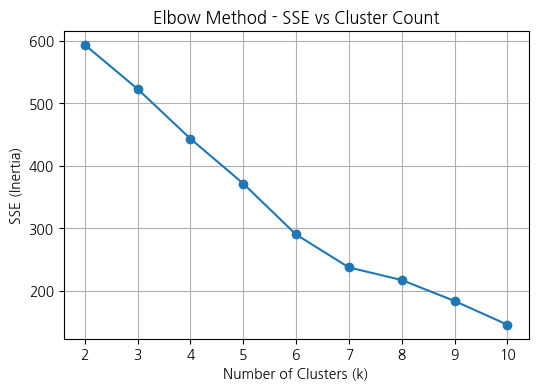

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_grouped)

# Elbow method: 군집 수에 따른 SSE(총 거리 제곱합) 계산
sse = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)  # inertia_는 SSE

# 시각화
plt.figure(figsize=(6, 4))
plt.plot(k_range, sse, marker='o')
plt.title("Elbow Method - SSE vs Cluster Count")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE (Inertia)")
plt.grid(True)
plt.show()


## **Silhouette Score (군집 응집도 vs k)**

1. Silhouette Score는 군집이 얼마나 잘 나뉘었는지 나타냄 (1에 가까울수록 좋음)

<br>

2. 해석
- k=2에서 가장 높고,
- k=3, k=4, k=7도 비교적 양호
- 이후 k≥8부터 점차 급격히 하락

<br>

3. 결론적으로,
- k=2는 응집도는 높지만 해석력이 떨어질 수 있음 (너무 큰 군집 2개로만 나뉘므로)
- k=4나 k=7은 Silhouette도 괜찮고 Elbow도 합리적인 포인트

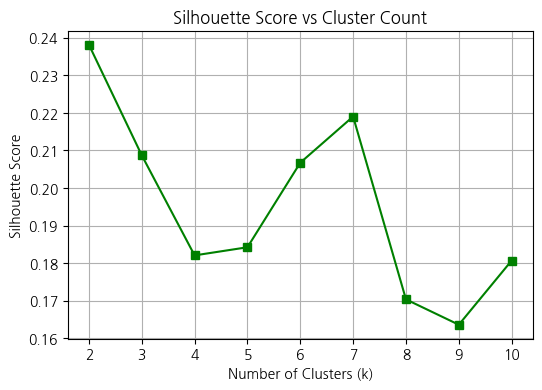

In [ ]:
from sklearn.metrics import silhouette_score

# silhouette score 계산
sil_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

# 시각화
plt.figure(figsize=(6, 4))
plt.plot(k_range, sil_scores, marker='s', color='green')
plt.title("Silhouette Score vs Cluster Count")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


## **Clustering**

- 군집 개수 : 4개
- 국가별 평균으로 계산

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_grouped)

# KMeans 클러스터링 (군집 수 n_clusters는 원하는 수로 조정)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# 결과 저장
df_grouped['cluster'] = cluster_labels


In [ ]:
# 클러스터별 평균값 계산
cluster_summary = df_grouped.groupby('cluster').mean()


## **Radar chart**

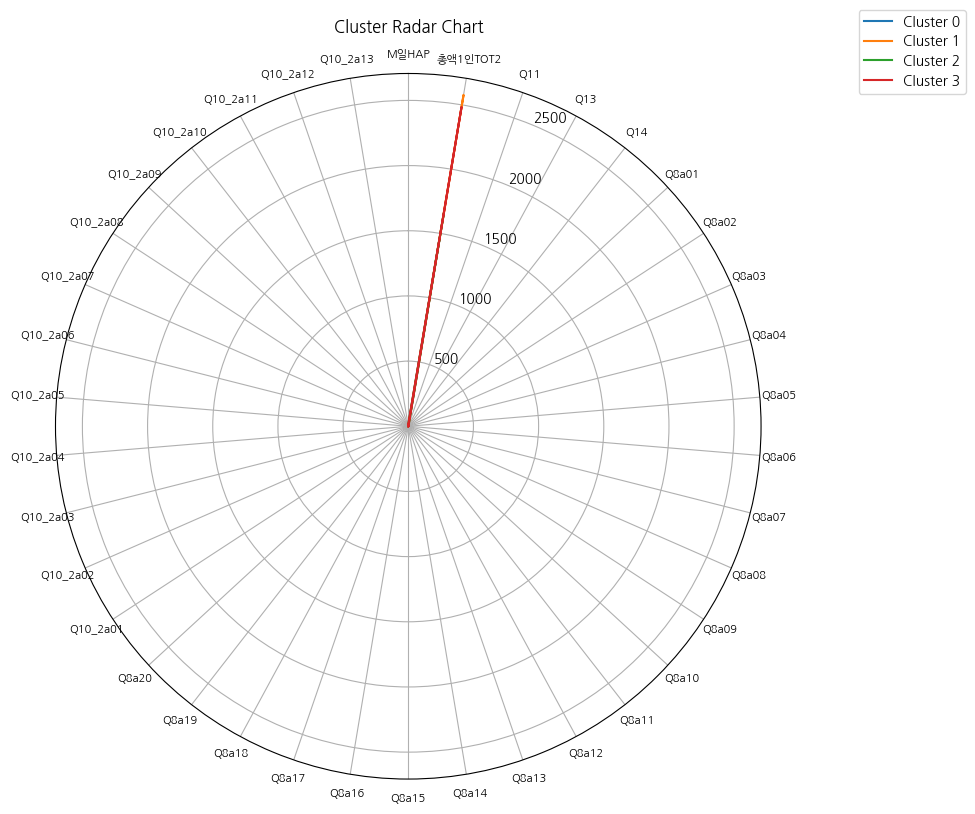

In [ ]:
# Radar chart용 함수
def plot_radar_chart(data, cluster_num):
    labels = data.columns.tolist()
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    for i in range(cluster_num):
        values = data.loc[i].tolist()
        values += values[:1]
        ax.plot(angles, values, label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.25)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=8)
    ax.set_title('Cluster Radar Chart', pad=30)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

# 시각화 실행
plot_radar_chart(cluster_summary, n_clusters)


## **PCA를 이용한 차원 축소**

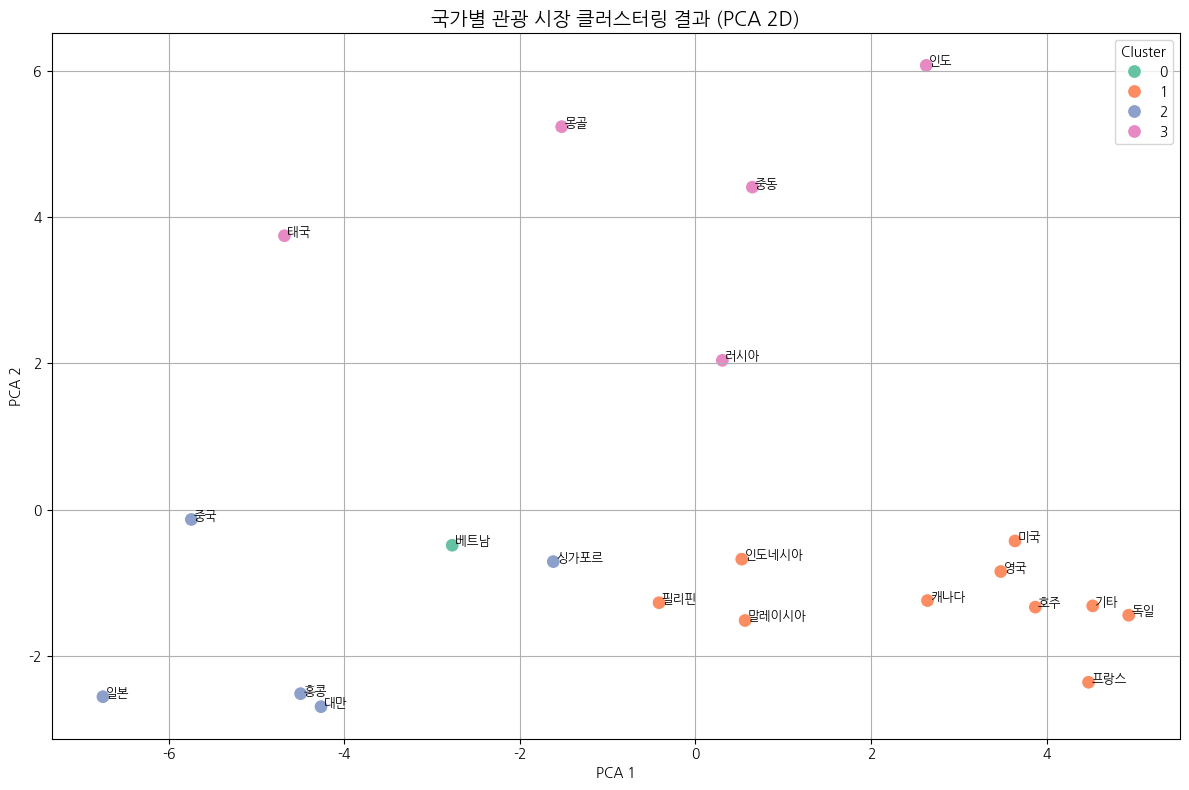

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

# 1. 데이터: df_grouped는 국가별 수치형 요약 (index: 국가 이름)
X = df_grouped  # 또는 df_grouped_final

# 2. 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. KMeans 클러스터링 (예: k=4)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# 4. PCA로 2차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 5. 시각화용 DataFrame 생성
df_pca = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"], index=X.index)
df_pca["Cluster"] = cluster_labels
df_pca["국가"] = df_pca.index

# 6. 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue="Cluster", palette="Set2", s=100)

# 국가 이름 표시
for i in range(len(df_pca)):
    plt.text(df_pca.iloc[i]["PCA1"] + 0.03,
             df_pca.iloc[i]["PCA2"],
             df_pca.iloc[i]["국가"],
             fontsize=9)

plt.title("국가별 관광 시장 클러스터링 결과 (PCA 2D)", fontsize=14)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


## 표준화 진행

In [ ]:
# 필요한 변수 설정
base_vars = ['D_NAT', 'M일HAP', '총액1인TOT2']
satisfaction_vars = ['Q11', 'Q13', 'Q14']
activity_vars = [f'Q8a{str(i).zfill(2)}' for i in range(1, 21)]
shopping_vars = [f'Q10_2a{str(i).zfill(2)}' for i in range(1, 14)]
final_vars = base_vars + satisfaction_vars + activity_vars + shopping_vars

# 데이터프레임 정리
df = df2024[final_vars].copy()

# 만족도 맵핑
satisfaction_map = {
    "⑤ 매우 만족": 5, "④ 만족": 4, "③ 보통": 3,
    "② 불만족": 2, "① 매우 불만족": 1,
    "⑤ 매우 그렇다": 5, "④ 대체로 그렇다": 4,
    "② 별로 그렇지 않다": 2, "① 전혀 그렇지 않다": 1,
    "해당없음": np.nan, "9 해당없음": np.nan
}
for col in satisfaction_vars:
    df[col] = df[col].map(satisfaction_map)

# 활동 및 쇼핑 변수 이진화
df[activity_vars + shopping_vars] = df[activity_vars + shopping_vars].notna().astype(int)

# 수치형 변환
for col in ['M일HAP', '총액1인TOT2']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 국가별 평균 계산
df_grouped = df.groupby('D_NAT').mean()

# 클러스터링
from sklearn.cluster import KMeans
X_scaled = StandardScaler().fit_transform(df_grouped)
kmeans = KMeans(n_clusters=4, random_state=42)
df_grouped['cluster'] = kmeans.fit_predict(X_scaled)

# 저장
df_grouped_final = df_grouped.copy()

## 표준화 후, 레이더 차트

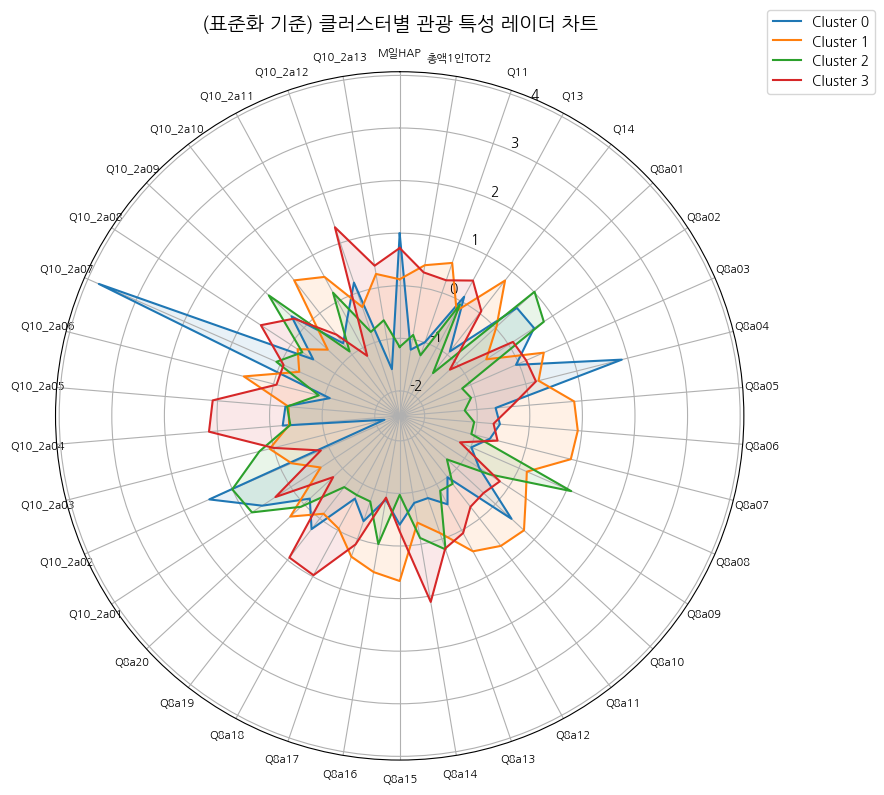

In [ ]:
# 클러스터별 평균 계산 후 표준화하여 Radar Chart 생성
from sklearn.preprocessing import StandardScaler

# 클러스터 분리
clusters = df_grouped_final['cluster']
features_only = df_grouped_final.drop(columns='cluster')

# 표준화
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_only)
df_scaled = pd.DataFrame(features_scaled, index=features_only.index, columns=features_only.columns)
df_scaled['cluster'] = clusters

# 클러스터별 평균
cluster_means_scaled = df_scaled.groupby('cluster').mean()

# Radar Chart 함수
def plot_radar_chart(data, labels, title):
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

    for i, row in data.iterrows():
        values = row.tolist()
        values += values[:1]
        ax.plot(angles, values, label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.1)

    ax.set_title(title, size=14, pad=30)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=8)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.tight_layout()
    plt.show()

# Radar Chart 시각화 실행
plot_radar_chart(cluster_means_scaled, labels=cluster_means_scaled.columns.tolist(),
                 title="(표준화 기준) 클러스터별 관광 특성 레이더 차트")



## 표준화 후, PCA

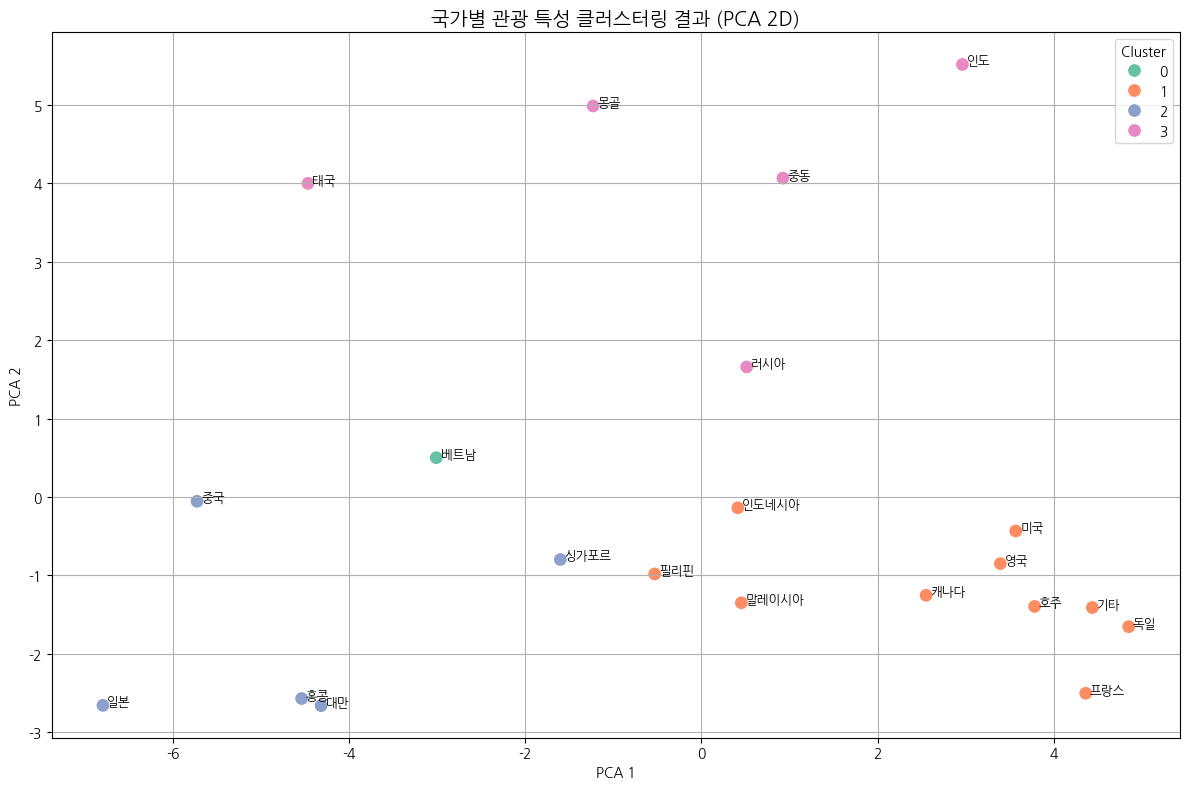

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# 1. 클러스터 포함된 표준화 데이터 재사용
features_scaled_df = pd.DataFrame(features_scaled, index=features_only.index, columns=features_only.columns)
features_scaled_df['cluster'] = clusters

# 2. PCA 차원 축소 (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features_scaled)
df_pca = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"], index=features_scaled_df.index)
df_pca["Cluster"] = clusters
df_pca["국가"] = df_pca.index
df_pca["국가"] = df_pca["국가"].str.replace(' ', '', regex=False)

# 3. 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue="Cluster", palette="Set2", s=100)

# 국가 이름 표시
for i in range(len(df_pca)):
    plt.text(df_pca.iloc[i]["PCA1"] + 0.05,
             df_pca.iloc[i]["PCA2"],
             df_pca.iloc[i]["국가"],
             fontsize=9)

plt.title("국가별 관광 특성 클러스터링 결과 (PCA 2D)", fontsize=14)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


## t-SNE를 이용한 차원 축소

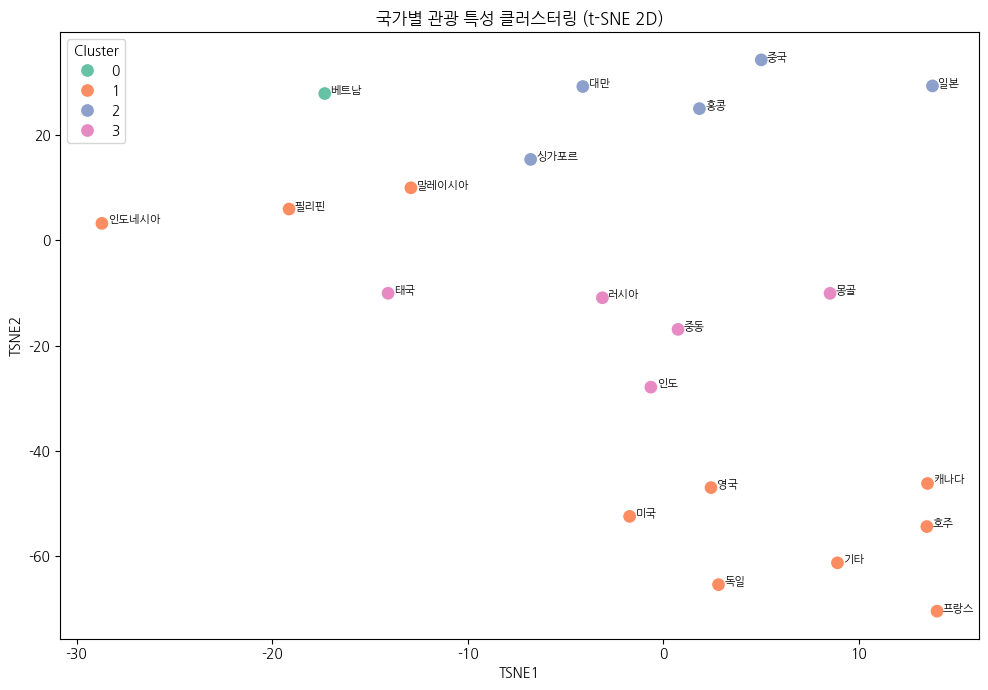

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# 입력 데이터는 반드시 StandardScaler 적용된 것 사용!
X_tsne = TSNE(n_components=2, random_state=42, perplexity=5).fit_transform(features_scaled)

# 결과 시각화
df_tsne = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"], index=features_only.index)
df_tsne["Cluster"] = clusters
df_tsne["국가"] = df_tsne.index
df_tsne["국가"] = df_tsne["국가"].str.replace(' ', '', regex=False)

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="Cluster", palette="Set2", s=100)
for i in range(len(df_tsne)):
    plt.text(df_tsne.iloc[i]["TSNE1"] + 0.3,
             df_tsne.iloc[i]["TSNE2"],
             df_tsne.iloc[i]["국가"],
             fontsize=8)
plt.title("국가별 관광 특성 클러스터링 (t-SNE 2D)")
plt.tight_layout()
plt.show()


## 데이터로 봤을 경우

In [ ]:
display(cluster_summary)

,M일HAP,총액1인TOT2,Q11,Q13,Q14,Q8a01,Q8a02,Q8a03,Q8a04,Q8a05,...,Q10_2a04,Q10_2a05,Q10_2a06,Q10_2a07,Q10_2a08,Q10_2a09,Q10_2a10,Q10_2a11,Q10_2a12,Q10_2a13
cluster,,,,,,,,,,,,,,,,,,,,,
0,14.300390,1462.132930,4.517555,4.525358,4.579974,0.782835,0.824447,0.598179,0.330299,0.429129,...,0.166450,0.115735,0.094928,0.392718,0.049415,0.054616,0.068921,0.067620,0.055917,0.009103
1,11.182016,2577.644415,4.676192,4.493332,4.725590,0.721616,0.756879,0.639820,0.205876,0.676522,...,0.156290,0.111104,0.183351,0.078189,0.057778,0.024609,0.177751,0.093137,0.038702,0.043122
2,6.553813,1656.704756,4.491395,4.507600,4.535495,0.835482,0.838226,0.517365,0.104931,0.331862,...,0.154279,0.113372,0.106252,0.114042,0.055242,0.073426,0.054850,0.083567,0.021211,0.026581
3,13.315317,2483.138659,4.641385,4.562130,4.662983,0.582213,0.794580,0.613428,0.201973,0.477860,...,0.283717,0.222545,0.149758,0.102802,0.077535,0.052546,0.084106,0.045141,0.094939,0.046073


| Cluster | 주요 국가         | 성격            | 전략 키워드      |
| ------- | ------------- | ------------- | ----------- |
| 0       | 미국, 독일, 프랑스 등 | 장기·고지출·다양한 활동 | 실속형 장기 콘텐츠  |
| 1       | 태국, 몽골        | 쇼핑 중심 고소득형    | 프리미엄 소비 마케팅 |
| 2       | 일본, 중국, 대만 등  | 단기·저비용 실용형    | 교통/쇼핑/맛집    |
| 3       | 필리핀, 말레이시아 등  | 한류·체험 중심 성장형  | 콘텐츠/SNS 연계  |


🟢 Cluster 0 – 장기체류 · 고지출 실속형
국가:

🇺🇸 미국, 🇬🇧 영국, 🇫🇷 프랑스, 🇩🇪 독일, 🇨🇦 캐나다

🇷🇺 러시아, 🇮🇳 인도, 🇦🇺 호주, 기타

특성 요약:

체류기간 길고, 지출 높음

다양한 활동에 참여 → 실속형 장기여행 수요

전략:

장기체류자 대상 스마트 여행패스, 교통·환승 편의 강화

개별여행자 맞춤형 관광 콘텐츠 추천

🟠 Cluster 1 – 고소득 · 브랜드 쇼핑 중시형
국가:

🇲🇳 몽골, 🇹🇭 태국

특성 요약:

쇼핑 항목 참여율 높음

프리미엄 소비 경향, 문화 콘텐츠 선호

전략:

한류 관련 쇼핑 인프라(면세점, K-뷰티) 집중 유치

모바일 쇼핑, 배송 연계 서비스 강화

🔵 Cluster 2 – 단기 저지출 · 실용형
국가:

🇯🇵 일본, 🇨🇳 중국, 🇭🇰 홍콩, 🇹🇼 대만, 🇻🇳 베트남

특성 요약:

체류 짧고 지출 적음

음식·쇼핑 위주의 실용 관광 집중

전략:

단기 자유여행객 대상 지역 맛집·쇼핑코스 추천

교통·언어 편의성 중심 정보 콘텐츠 제공

🟣 Cluster 3 – 한류 · 체험 콘텐츠 중심 성장형
국가:

🇵🇭 필리핀, 🇲🇾 말레이시아, 🇮🇩 인도네시아, 🇸🇬 싱가포르, 중동

특성 요약:

K-POP, K-뷰티, 한류 쇼핑 등 몰입형 문화 수요 강함

재방문 의향, 만족도도 높음

전략:

공연/드라마 연계 관광 루트 개발

SNS 기반 한류 콘텐츠 확산 (틱톡, 유튜브 등)



## 표준화 진행

In [ ]:
# 필요한 변수 설정
base_vars = ['D_NAT', 'M일HAP', '총액1인TOT2']
satisfaction_vars = ['Q11', 'Q13', 'Q14']
activity_vars = [f'Q8a{str(i).zfill(2)}' for i in range(1, 21)]
shopping_vars = [f'Q10_2a{str(i).zfill(2)}' for i in range(1, 14)]
final_vars = base_vars + satisfaction_vars + activity_vars + shopping_vars

# 데이터프레임 정리
df = df2024[final_vars].copy()

# 만족도 맵핑
satisfaction_map = {
    "⑤ 매우 만족": 5, "④ 만족": 4, "③ 보통": 3,
    "② 불만족": 2, "① 매우 불만족": 1,
    "⑤ 매우 그렇다": 5, "④ 대체로 그렇다": 4,
    "② 별로 그렇지 않다": 2, "① 전혀 그렇지 않다": 1,
    "해당없음": np.nan, "9 해당없음": np.nan
}
for col in satisfaction_vars:
    df[col] = df[col].map(satisfaction_map)

# 활동 및 쇼핑 변수 이진화
df[activity_vars + shopping_vars] = df[activity_vars + shopping_vars].notna().astype(int)

# 수치형 변환
for col in ['M일HAP', '총액1인TOT2']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 국가별 평균 계산
df_grouped = df.groupby('D_NAT').mean()

# 클러스터링
from sklearn.cluster import KMeans
X_scaled = StandardScaler().fit_transform(df_grouped)
kmeans = KMeans(n_clusters=6, random_state=42)
df_grouped['cluster'] = kmeans.fit_predict(X_scaled)

# 저장
df_grouped_final = df_grouped.copy()

## 표준화 후, 레이더 차트

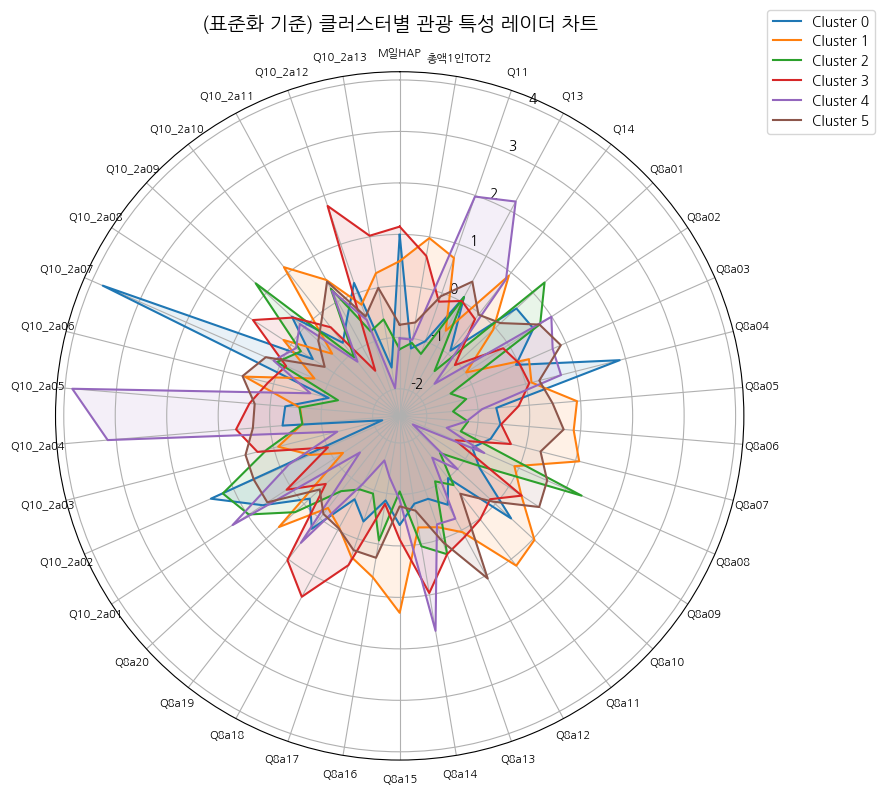

In [ ]:
# 클러스터별 평균 계산 후 표준화하여 Radar Chart 생성
from sklearn.preprocessing import StandardScaler

# 클러스터 분리
clusters = df_grouped_final['cluster']
features_only = df_grouped_final.drop(columns='cluster')

# 표준화
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_only)
df_scaled = pd.DataFrame(features_scaled, index=features_only.index, columns=features_only.columns)
df_scaled['cluster'] = clusters

# 클러스터별 평균
cluster_means_scaled = df_scaled.groupby('cluster').mean()

# Radar Chart 함수
def plot_radar_chart(data, labels, title):
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

    for i, row in data.iterrows():
        values = row.tolist()
        values += values[:1]
        ax.plot(angles, values, label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.1)

    ax.set_title(title, size=14, pad=30)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=8)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.tight_layout()
    plt.show()

# Radar Chart 시각화 실행
plot_radar_chart(cluster_means_scaled, labels=cluster_means_scaled.columns.tolist(),
                 title="(표준화 기준) 클러스터별 관광 특성 레이더 차트")



## 표준화 후, PCA

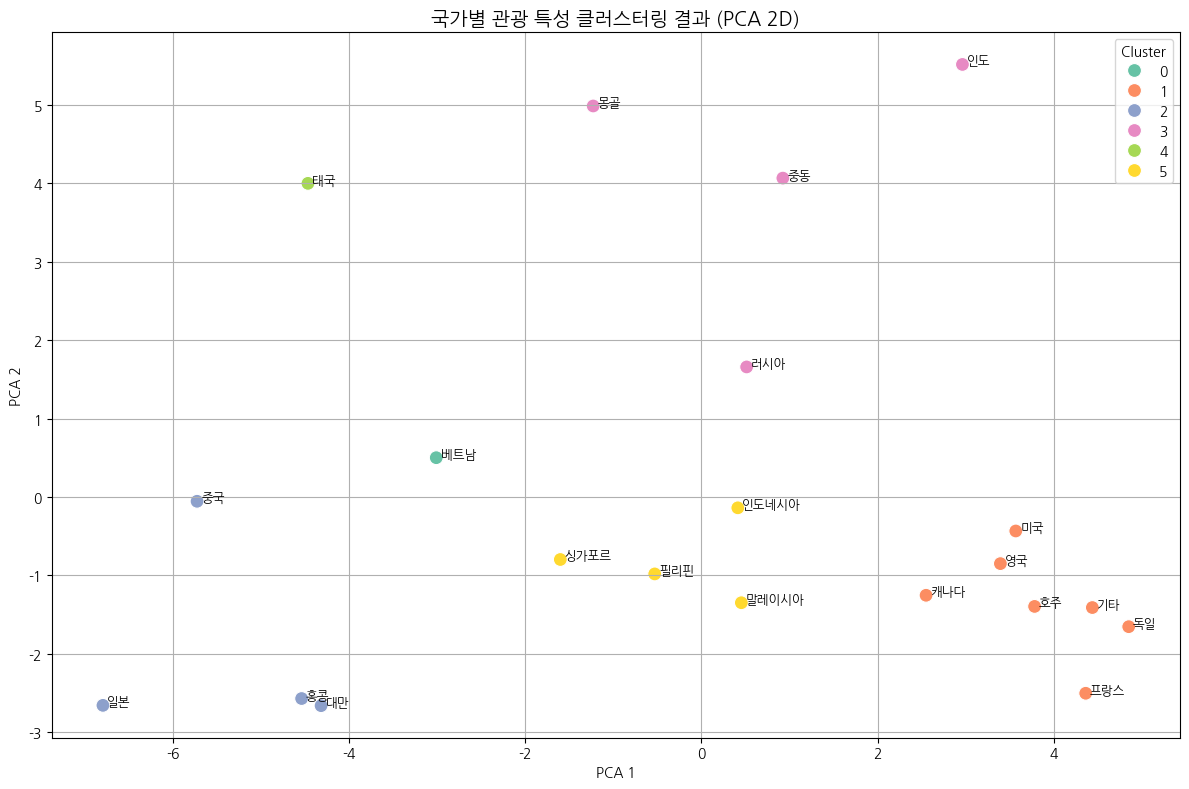

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# 1. 클러스터 포함된 표준화 데이터 재사용
features_scaled_df = pd.DataFrame(features_scaled, index=features_only.index, columns=features_only.columns)
features_scaled_df['cluster'] = clusters

# 2. PCA 차원 축소 (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features_scaled)
df_pca = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"], index=features_scaled_df.index)
df_pca["Cluster"] = clusters
df_pca["국가"] = df_pca.index
df_pca["국가"] = df_pca["국가"].str.replace(' ', '', regex=False)

# 3. 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue="Cluster", palette="Set2", s=100)

# 국가 이름 표시
for i in range(len(df_pca)):
    plt.text(df_pca.iloc[i]["PCA1"] + 0.05,
             df_pca.iloc[i]["PCA2"],
             df_pca.iloc[i]["국가"],
             fontsize=9)

plt.title("국가별 관광 특성 클러스터링 결과 (PCA 2D)", fontsize=14)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


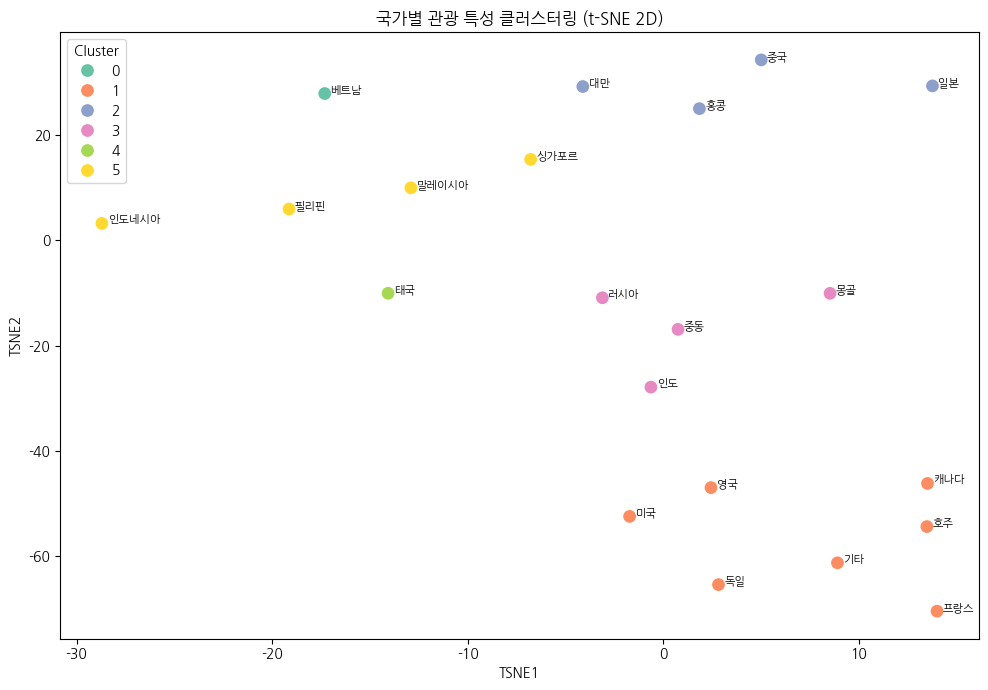

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# 입력 데이터는 반드시 StandardScaler 적용된 것 사용!
X_tsne = TSNE(n_components=2, random_state=42, perplexity=5).fit_transform(features_scaled)

# 결과 시각화
df_tsne = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"], index=features_only.index)
df_tsne["Cluster"] = clusters
df_tsne["국가"] = df_tsne.index
df_tsne["국가"] = df_tsne["국가"].str.replace(' ', '', regex=False)

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="Cluster", palette="Set2", s=100)
for i in range(len(df_tsne)):
    plt.text(df_tsne.iloc[i]["TSNE1"] + 0.3,
             df_tsne.iloc[i]["TSNE2"],
             df_tsne.iloc[i]["국가"],
             fontsize=8)
plt.title("국가별 관광 특성 클러스터링 (t-SNE 2D)")
plt.tight_layout()
plt.show()
